# Supervised Learning Primer


This chapter is heavily based on the chapter "Modelling with Decision Trees" of "Programming Collective Intelligence" by Toby Segaran.

## Imports and setup

In [1]:
import os
import sys

sys.path.append(os.getcwd())
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import data_utils
import seaborn as sns

%matplotlib inline

In [2]:
fn_coauthors = "ca-HepPh.txt.gz"
df_coauthors = (
    data_utils.load_dataset_from_web(fn_coauthors)
    .rename(columns={0: "source", 1: "target"})
    .astype(str)
)
df_coauthors

,source,target
0,17010,1943
1,17010,2489
2,17010,3426
3,17010,4049
4,17010,16961
...,...,...
237005,71913,45004
237006,71913,77145
237007,42800,74899
237008,87816,5319


In [3]:
df_features = data_utils.load_dataset_from_local(
    "df_node_disambiguation_task"
).set_index("node_id", drop=True)

In [4]:
df_features

,betweenness_ego,closeness_ego,delta_clustering_ego,delta_diameter_ego,n_components_no_self_ego,delta_density_ego,betweenness_centrality,closeness_centrality,same_community@0.01,n_neighboring_communities@0.01,...,mean_same,mean_neighboring,percentile_same_10,percentile_neighboring_10,percentile_same_25,percentile_neighboring_25,percentile_same_75,percentile_neighboring_75,percentile_same_90,percentile_neighboring_90
node_id,,,,,,,,,,,,,,,,,,,,,
17010,0.654722,1.0,-0.293498,3,1,-0.064359,0.000705,0.247027,1.0,1,...,0.700000,5.1,0.50,3.7,0.590000,4.00,0.820000,6.00,0.856,6.3
1943,0.570370,1.0,-0.009293,9,2,-0.117172,0.000338,0.217200,1.0,1,...,0.560000,3.2,0.50,2.8,0.500000,3.00,0.500000,3.75,0.640,4.1
2489,0.528987,1.0,-0.165630,2,1,-0.051465,0.000661,0.249743,1.0,1,...,0.630000,7.4,0.36,4.6,0.516667,5.50,0.750000,9.75,0.880,11.0
3426,0.000000,1.0,-1.000000,0,1,0.000000,0.000000,0.210884,1.0,1,...,0.800000,1.4,0.50,1.0,0.500000,1.00,1.000000,2.00,1.000,2.0
4049,0.713508,1.0,-0.224087,17,4,-0.088751,0.000742,0.234481,1.0,1,...,0.655556,5.7,0.60,3.7,0.611111,5.25,0.666667,7.00,0.700,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27966,0.000000,1.0,0.000000,-1,1,-1.000000,0.000000,0.000084,1.0,1,...,1.000000,1.0,1.00,1.0,1.000000,1.00,1.000000,1.00,1.000,1.0
41545,0.000000,1.0,0.000000,-1,1,-1.000000,0.000000,0.000084,1.0,1,...,1.000000,1.0,1.00,1.0,1.000000,1.00,1.000000,1.00,1.000,1.0
56583,0.000000,1.0,0.000000,-1,1,-1.000000,0.000000,0.000084,1.0,1,...,1.000000,1.0,1.00,1.0,1.000000,1.00,1.000000,1.00,1.000,1.0


In [5]:
df_features["is_scrambled"] = df_features.index.str.contains("scrambled")
df_features.is_scrambled.value_counts()

is_scrambled
False    11857
True        60
Name: count, dtype: int64

For demonstration purposes, we willl use all the cases where `is_scrambled` is `True`, and only a fraction of the cases where `is_scrambled` is `False`. This is to make the dataset more balanced.
This technique is sometimes called "undersampling".

## Building a simple decision tree classifier

The classifier that we will build here is heavily influenced by the book "Programming Collective Intelligence" by Toby Segaran. I only make some minor modifications to the code to make it more readable and to use pandas DataFrames.

In [6]:
sel = df_features.is_scrambled | (np.random.rand(len(df_features)) < 0.005)
df_classification = df_features[sel].copy()
df_classification.is_scrambled.value_counts()

is_scrambled
False    82
True     60
Name: count, dtype: int64

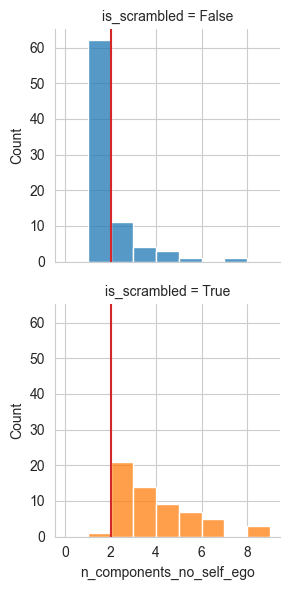

In [7]:
feature = "n_components_no_self_ego"
# faceted histplot
g = sns.FacetGrid(df_classification, row="is_scrambled", hue="is_scrambled")
g.map(sns.histplot, feature, bins=list(range(0, 10)), kde=False)
for ax in g.axes.flatten():
    ax.axvline(2, color="C3")

We see that the feature `n_components_no_self_ego` is very different in the two classes. This is a good sign that it might be useful for classification.
We could argue that if a node has a value of `n_components_no_self_ego` greater than 2, then it is MORE likely to be a scrambled node, than a non-scrambled node. If we combine this approach with other features, we might be able to build a classifier.

Classifier that asks questions like: "Is the value of `n_components_no_self_ego` greater than 2?" and then makes a decision based on the answer is called a "decision tree".

A decision tree is composed of nodes, where each node asks a question about a feature, and based on the answer, the classifier moves to the next node. The final nodes are called "leaves" and they contain the decision of the classifier.

In [8]:
class DecisionNode:
    def __init__(
        self,
        col: str,
        value=None,
        results: dict = None,
        tb: "DecisionNode" = None,
        fb: "DecisionNode" = None,
    ):
        """
        Decision tree node
        Args:
            col: column index or name
            value: value to compare with
            results: a dictionary of results for this branch. None for nodes, not None for leaves
            tb: DecisionNode of True branch
            fb: DecisionNode of False branch
        """
        self.col = col
        self.value = value
        self.results = results
        self.tb = tb
        self.fb = fb

OK, now we need to build the decision tree. The algorithm is recursive, and it is called "recursive partitioning". The algorithm is as follows:
1. Check if the dataset is empty. If it is, return a leaf node with the most common target value.
2. Check if the dataset only contains one target value. If it does, return a leaf node with that target value.
3. Find the best feature to split on. The best feature is the one that maximizes the information gain.
4. Split the dataset into two parts based on the best feature.
5. Recursively build the decision tree for the two parts.
6. Return a DecisionNode with the best feature, and the two branches.
7. Done.

The steps 1 - 3 are trivial, but the step 3 is a bit more complicated. To start, we will build a function that divides the dataset based on a specific column and a specific value.

In [9]:
def divide_dataframe(
    df: pd.DataFrame, column: str, value
) -> (pd.DataFrame, pd.DataFrame):
    """
    Divides a DataFrame on a specific column. Can handle numeric or nominal values.

    Args:
        df (pd.DataFrame): The DataFrame to divide.
        column (str): The name of the column to divide on.
        value: The value to compare the column's entries against.

    Returns:
        tuple: Two DataFrames representing the divided sets.
    """
    if isinstance(value, (int, float)):
        split_function = lambda row: row[column] >= value
    else:
        split_function = lambda row: row[column] == value

    set1 = df[df.apply(split_function, axis=1)].copy()
    set2 = df[~df.apply(split_function, axis=1)].copy()

    return set1, set2

In [10]:
df_above, df_below = divide_dataframe(df_classification, "n_components_no_self_ego", 2)

In [11]:
df_above.is_scrambled.value_counts()

is_scrambled
True     59
False    20
Name: count, dtype: int64

In [12]:
df_below.is_scrambled.value_counts()

is_scrambled
False    62
True      1
Name: count, dtype: int64

OK, we were able to split the dataset based on the feature `n_components_no_self_ego`. We can see that our guess a valid one: the `df_above` has three tiems more scrambled nodes than non-scrambled nodes, while `df_below` has only one scrambled node, and the rest are non-scrambled.

Now we need to build a function that calculates how good the partition is. One way to comput this is to use **Gini impurity**. The Gini impurity is a measure of how often a randomly chosen element would be incorrectly classified. It is calculated as follows:

In [13]:
def gini_impurity(labels: pd.Series) -> float:
    """
    Calculates the Gini impurity for a set of labels.

    Args:
        labels (pd.Series): The labels of the dataset.

    Returns:
        float: The Gini impurity.
    """
    total = len(labels)
    counts = labels.value_counts()
    imp = 1 - sum((count / total) ** 2 for count in counts)
    return imp

In [14]:
gini_impurity(pd.Series(np.ones(10, dtype=bool)))  # a very "pure" set, expect 0

0.0

In [15]:
gini_impurity(pd.Series(np.random.randint(0, 2, 100)))  #  a random set, expect 0.5

0.4838

In [16]:
gini_impurity(pd.Series(np.random.rand(100)))  # expect something close to 1

0.99

The Gini impurity is a number between 0 and 1. The closer to 0, the better the partition is. The closer to 1, the worse the partition is.

What is the Gini impurity of the `df_classification` DataFrame and of the `df_above` and `df_below` DataFrames?

In [17]:
gini_impurity(df_classification.is_scrambled), gini_impurity(
    df_above.is_scrambled
), gini_impurity(df_below.is_scrambled)

(0.48799841301329105, 0.3781445281204936, 0.031242126480221843)

Another way to measure the quality of a partition is to use **Entropy**. The entropy is a measure of the amount of uncertainty in the dataset. 

In [18]:
def entropy(labels: pd.Series) -> float:
    """
    Calculates the entropy for a set of labels.

    Args:
        labels (pd.Series): The labels of the dataset.

    Returns:
        float: The entropy.
    """
    total = len(labels)
    counts = labels.value_counts()
    ent = -sum(
        (count / total) * np.log2(count / total) for count in counts if count != 0
    )
    return ent

In [19]:
entropy(pd.Series(np.ones(10, dtype=bool)))  # a very "pure" set, expect 0

-0.0

In [20]:
entropy(pd.Series(np.random.randint(0, 2, 100)))  #  a random set,

0.9997114417528099

In [21]:
entropy(pd.Series(np.random.rand(100)))  # entropy isn't bounded

6.6438561897747395

In [22]:
entropy(df_classification.is_scrambled), entropy(df_above.is_scrambled), entropy(
    df_below.is_scrambled
)

(0.9826154285526119, 0.8162554088088008, 0.11759466565886476)

How do we know that the parameter we selected and the threshold we selected are the best ones? We need to calculate the information gain. The information gain is the difference between the entropy (or the gini impurity) of the parent node and the weighted sum of the entropies of the child nodes.

In [23]:
threshold_values = df_classification.n_components_no_self_ego.unique()
threshold_values = np.sort(np.append(threshold_values, 0))
entropy_values = []
for value in threshold_values:
    set1, set2 = divide_dataframe(df_classification, "n_components_no_self_ego", value)
    p = len(set1) / len(df_classification)
    entropy_s1 = entropy(set1.is_scrambled)
    entropy_s2 = entropy(set2.is_scrambled)
    weighted_entropy = p * entropy_s1 + (1 - p) * entropy_s2
    entropy_values.append((value, entropy_s1, entropy_s2, weighted_entropy))
entropy_values = pd.DataFrame(
    entropy_values,
    columns=["threshold", "entropy_below", "entropy_above", "weighted_entropy"],
)

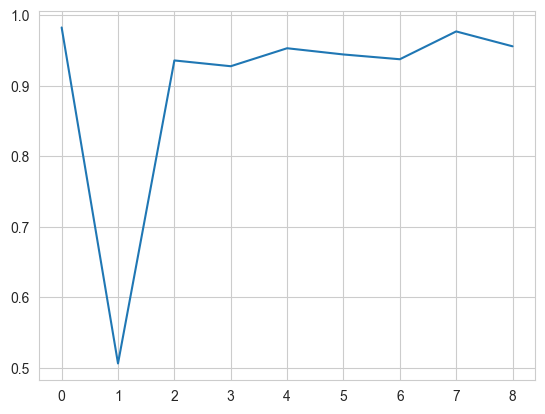

In [24]:
fig, ax = plt.subplots()
ax.plot(
    entropy_values.threshold, entropy_values.weighted_entropy, label="weighted entropy"
)

What we see is that the entropy at the threshold `1` is the lowest. This means that the information gain is maximized at this threshold. Indeed, there are no scrambled nodes below the threshold

In [25]:
set1, set2 = divide_dataframe(df_classification, "n_components_no_self_ego", 1)
print("set1")
print(set1.is_scrambled.value_counts())
print("set2")
print(set2.is_scrambled.value_counts())

set1
is_scrambled
False    82
True     60
Name: count, dtype: int64
set2
Series([], Name: count, dtype: int64)


Now, we can build a function that scans all the columns and all the values in the columns to find the best split. We will use **information gain**, which is the difference between the entropy of the parent node and the weighted sum of the entropies of the child nodes.

In [26]:
def build_tree(df: pd.DataFrame, scoref=entropy) -> DecisionNode:
    """
    Builds a decision tree.

    Args:
        df (pd.DataFrame): The DataFrame to build the tree from.
        scoref (function): The function to calculate the score (e.g., entropy or gini impurity).

    Returns:
        DecisionNode: The root of the decision tree.
    """
    if df.empty:
        return DecisionNode()

    current_score = scoref(df.iloc[:, -1])

    # Set up some variables to track the best criteria
    best_gain = 0.0
    best_criteria = None
    best_sets = None

    for col in df.columns[:-1]:
        # Generate the list of different values in this column
        column_values = df[col].unique()

        # Now try dividing the rows up for each value in this column
        for value in column_values:
            set1, set2 = divide_dataframe(df, col, value)

            # Information gain
            p = float(len(set1)) / len(df)
            gain = (
                current_score
                - p * scoref(set1.iloc[:, -1])
                - (1 - p) * scoref(set2.iloc[:, -1])
            )

            if gain > best_gain and not set1.empty and not set2.empty:
                best_gain = gain
                best_criteria = (col, value)
                best_sets = (set1, set2)

    # Create the subbranches
    if best_gain > 0:
        trueBranch = build_tree(best_sets[0], scoref)
        falseBranch = build_tree(best_sets[1], scoref)
        return DecisionNode(
            col=best_criteria[0], value=best_criteria[1], tb=trueBranch, fb=falseBranch
        )

    return DecisionNode(col=None, results=(df.is_scrambled.value_counts()))

Note, how the function above accepts another function as one of its arguments. This is a very powerful concept in Python. It allows us to pass a function that calculates the score. This way, we can easily switch between Gini impurity and entropy.

In [27]:
t = build_tree(df_classification)

In [28]:
t

In [29]:
def print_tree(tree: DecisionNode, indent: str = ""):
    """
    Prints the decision tree.

    Args:
        tree (DecisionNode): The decision tree to print.
        indent (str): The indentation for the current level.
    """
    # Is this a leaf node?
    if tree.results is not None:
        print(str(tree.results))
    else:
        # Print the criteria
        print(f"{tree.col}:{tree.value}?")
        # Print the branches
        print(f"{indent}T->", end="")
        print_tree(tree.tb, indent + "  ")
        print(f"{indent}F->", end="")
        print_tree(tree.fb, indent + "  ")

In [30]:
print_tree(t)

n_components_no_self_ego:1?
T->delta_density_ego:-0.1333333333333334?
  T->is_scrambled
False    50
Name: count, dtype: int64
  F->delta_diameter_ego:-1?
    T->is_scrambled
False    12
Name: count, dtype: int64
    F->is_scrambled
True    1
Name: count, dtype: int64
F->betweenness_centrality:0.0007523883009496?
  T->n_neighboring_communities@3.11:5?
    T->is_scrambled
False    1
Name: count, dtype: int64
    F->is_scrambled
True    36
Name: count, dtype: int64
  F->n_neighboring_communities@4.00:2?
    T->is_scrambled
True    8
Name: count, dtype: int64
    F->same_community@3.56:0.4545454545454545?
      T->percentile_same_75:0.631578947368421?
        T->closeness_centrality:0.183818578191441?
          T->percentile_same_90:0.98?
            T->is_scrambled
False    7
Name: count, dtype: int64
            F->same_community@0.90:0.6666666666666666?
              T->percentile_same_90:0.9307692307692308?
                T->betweenness_ego:0.2046783625730994?
                  T->is_

Now, we can use the tree to make predictions. We will use the following function:

In [31]:
def classify(observation: pd.Series, tree: DecisionNode):
    """
    Classifies an observation using the decision tree.

    Args:
        observation (pd.Series): The observation to classify.
        tree (DecisionNode): The decision tree to use for classification.

    Returns:
        The classification result.
    """
    if tree.results is not None:
        return tree.results
    else:
        v = observation[tree.col]
        branch = None
        if isinstance(v, (int, float)):
            if v >= tree.value:
                branch = tree.tb
            else:
                branch = tree.fb
        else:
            if v == tree.value:
                branch = tree.tb
            else:
                branch = tree.fb
        return classify(observation, branch)

In [32]:
classify(df_classification.iloc[0], t)

is_scrambled
False    50
Name: count, dtype: int64

What we see is that the tree classifies the first case as non-scrambled, and it tells us how many non-scrambled cases of the training set are in the leaf node.

Of course, the stone age is over, and we don't need to build decision trees by hand. We can use the `DecisionTreeClassifier` from the `sklearn` package.

In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(criterion="entropy")

Every model class in `sklearn` ecosystem has two important functions: `fit` and `predict`

In [34]:
tree.fit(df_classification.iloc[:, :-1], df_classification.is_scrambled)

DecisionTreeClassifier(criterion='entropy')

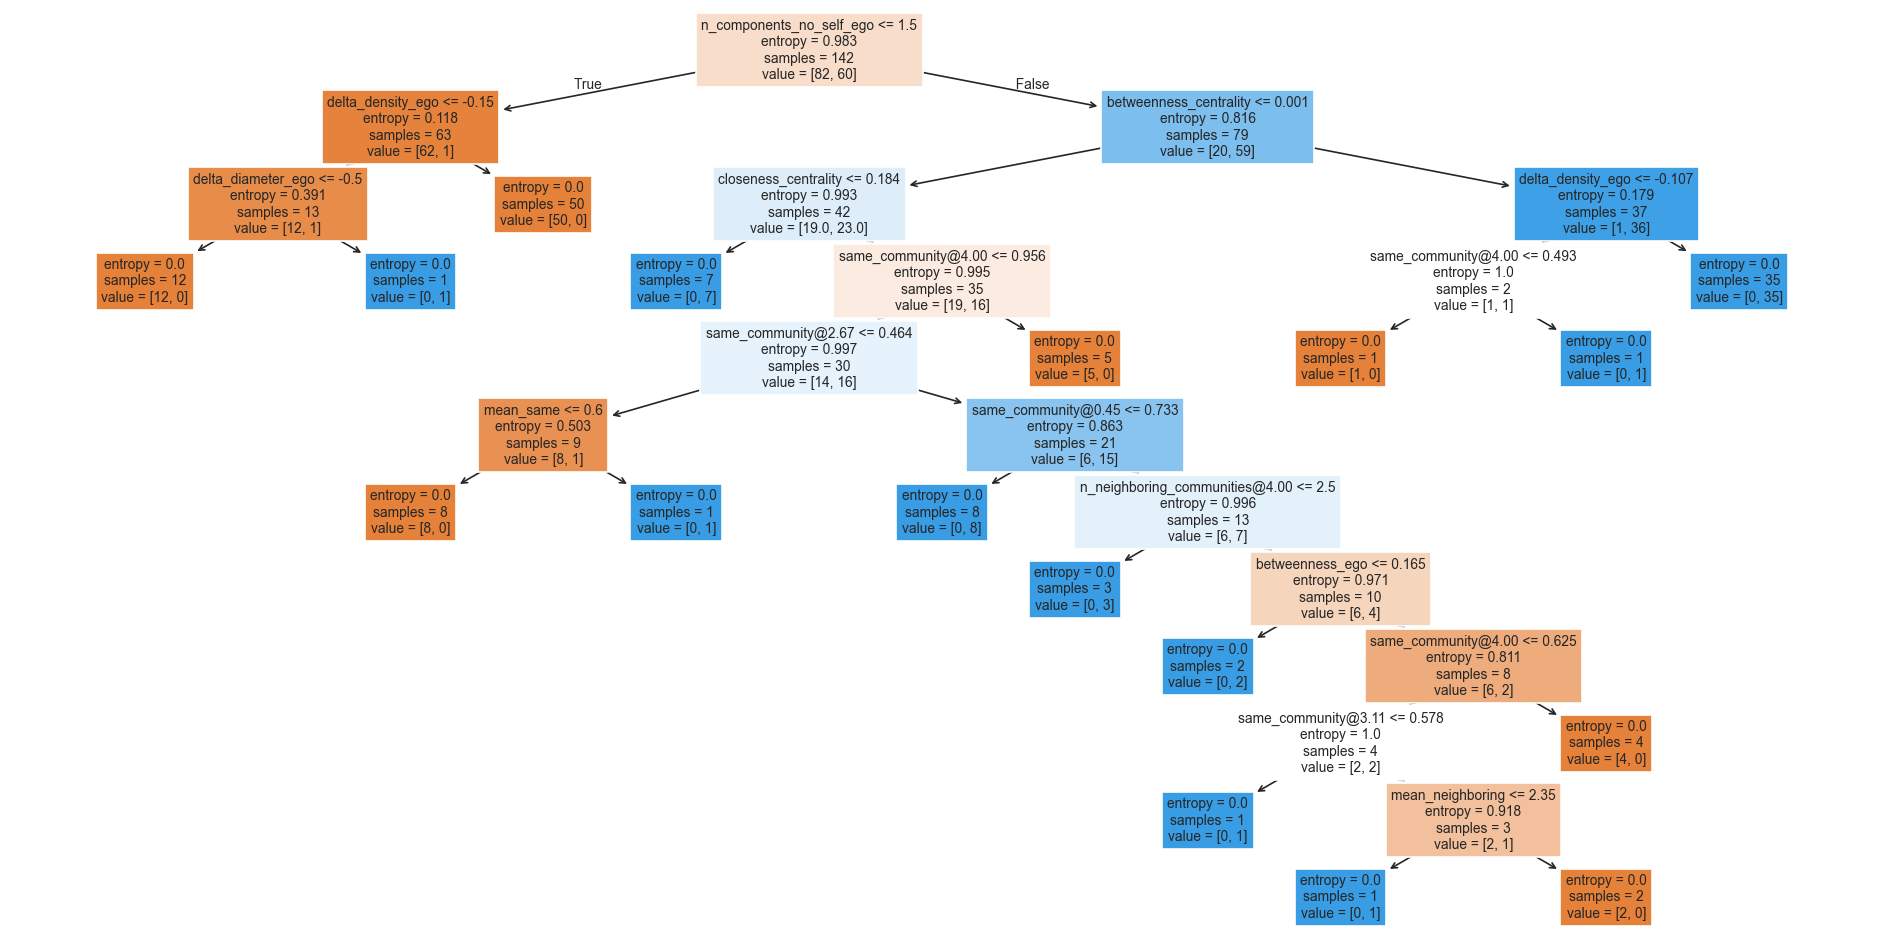

In [35]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=120)
plot_tree(tree, ax=ax, filled=True, feature_names=df_classification.columns[:-1]);

The tree is a bit more complex than the one we built by hand, but it is still understandable. The tree asks questions about the features and based on the answers, it classifies the nodes.

More complex trees are more flexible and are capable of catching more nuiances, but at the same time, they are more prone to overfitting. Overfitting is a phenomenon where the model is too complex and it learns the noise in the data, instead of the signal. This results in poor generalization performance.

One way to avoid overfitting is to limit the depth of the tree or to prune the tree. Pruning is a process where we remove some of the branches of the tree to make it simpler.

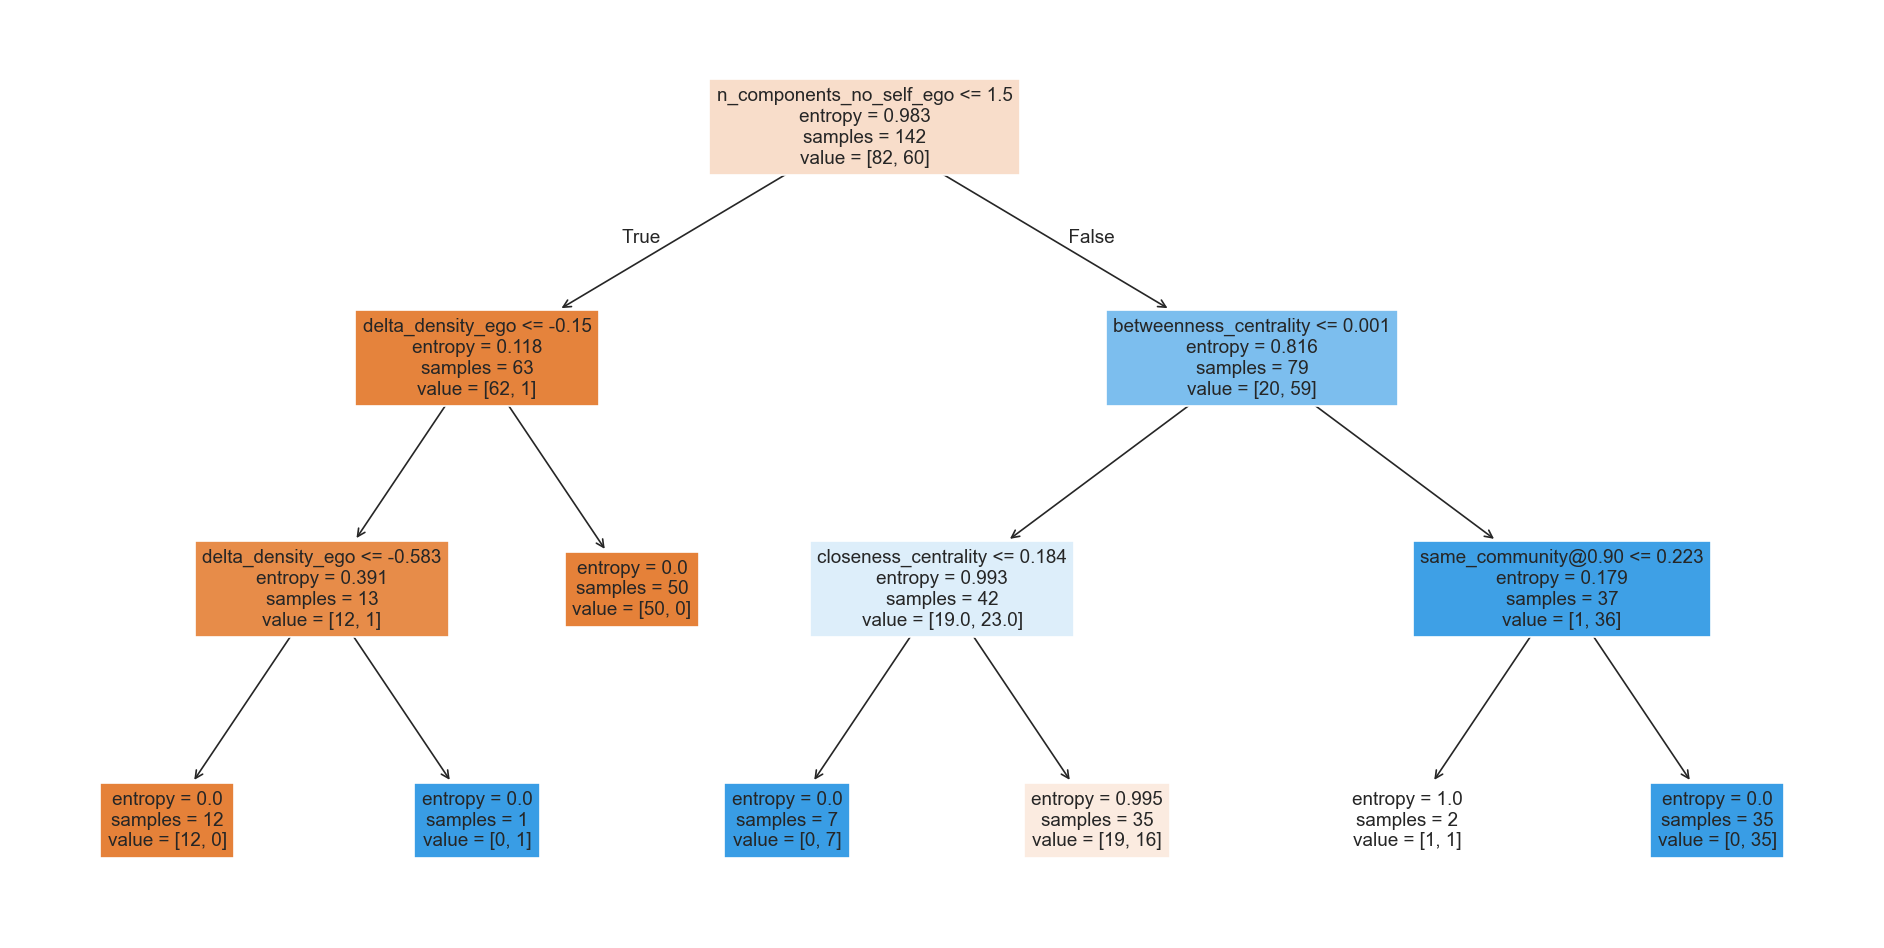

In [36]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3)
tree.fit(df_classification.iloc[:, :-1], df_classification.is_scrambled)
fig, ax = plt.subplots(figsize=(20, 10), dpi=120)
plot_tree(tree, ax=ax, filled=True, feature_names=df_classification.columns[:-1]);

## Ensemble methods


Another way to avoid overfitting is to use **ensemble methods**. Ensemble methods are methods that combine multiple models to make a decision. One of the most popular ensemble methods is the **Random Forest**. A random forest is a collection of trees, each trained on a different subset of the data. The final decision is made by aggregating the decisions of the individual trees. 

In [37]:
def build_a_forest(
    df: pd.DataFrame, n_trees: int, n_samples: int, scoref=entropy
) -> list:
    """
    Builds a random forest.

    Args:
        df (pd.DataFrame): The DataFrame to build the forest from.
        n_trees (int): The number of trees in the forest.
        n_samples (int): The number of samples to use for each tree.
        scoref (function): The function to calculate the score (e.g., entropy or gini impurity).

    Returns:
        list: The list of trees in the forest.
    """
    trees = []
    for _ in tqdm(range(n_trees), leave=False, total=n_trees):
        sample = df.sample(n=n_samples, replace=True)
        tree = build_tree(sample, scoref)
        trees.append(tree)
    return trees

To make a decision, we can use the majority vote of the trees in the forest. However, we can also compute the probability of the decision. The probability is the fraction of trees that voted for a specific decision.

In [38]:
forest = build_a_forest(df_classification, n_trees=10, n_samples=100)

  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
def forest_probability(observation: pd.Series, forest: list) -> float:
    """
    Calculates the probability of a decision using a random forest.

    Args:
        observation (pd.Series): The observation to calculate the probability for.
        forest (list): The list of trees in the forest.

    Returns:
        float: The probability of the decision.
    """
    votes = np.mean([classify(observation, tree).index[0] for tree in forest])
    return votes

In [40]:
case = df_classification.iloc[0]
prediction = forest_probability(case, forest)
print(f"Prediction: {prediction}")

Prediction: 0.0


Of course, the `sklearn` package has a `RandomForestClassifier` that we can use.

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators=10,
    criterion="entropy",
    max_depth=5,  # it's OK to have deeper trees here, because we are using a forest
)
forest.fit(df_classification, df_classification.is_scrambled)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10)

In [42]:
forest.predict(df_classification)

array([False,  True, False,  True,  True,  True, False, False, False,
       False,  True,  True,  True, False,  True,  True, False, False,
        True, False, False,  True, False,  True, False,  True,  True,
        True, False,  True, False, False, False,  True,  True,  True,
       False, False,  True,  True,  True, False,  True, False, False,
       False,  True,  True,  True,  True,  True, False,  True, False,
       False,  True,  True, False,  True, False,  True, False,  True,
        True, False,  True, False, False,  True, False,  True,  True,
        True, False,  True, False, False,  True, False, False, False,
        True, False,  True,  True, False,  True, False,  True,  True,
       False, False, False, False, False, False, False,  True,  True,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True,  True, False,
       False, False,

The `predict` method outputs the class labels, but many objects in `sklearn` have a `predict_proba` method that outputs the probabilities.

In [43]:
proba = np.round(forest.predict_proba(df_classification), 3)
proba = pd.DataFrame(proba, columns=forest.classes_)
proba

,False,True
0,1.000,0.000
1,0.000,1.000
2,0.965,0.035
3,0.000,1.000
4,0.000,1.000
...,...,...
137,1.000,0.000
138,1.000,0.000
139,1.000,0.000
140,1.000,0.000


## Measuring the performance

In supervised learning, the ground truth is always known (or assumed to be known). This means that we can calculate the accuracy of the model. The accuracy is the fraction of correctly classified cases. The `sklearn` package has a plethora of functions to evaluate ML models. The simplest one is  `classification_report`.

In [44]:
import sklearn.metrics

observed = df_classification.is_scrambled
predicted = forest.predict(df_classification)
print(sklearn.metrics.classification_report(observed, predicted))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99        82
        True       1.00      0.98      0.99        60

    accuracy                           0.99       142
   macro avg       0.99      0.99      0.99       142
weighted avg       0.99      0.99      0.99       142



**NOTE** in this notebook, I don't split the data into training and testing sets. Using a single set is very convenient when we want to provide toy examples for demonstration purposes, bus is a **HUGE** no-no in practice. In practice, we always split the data into training and testing sets. The training set is used to train the model, while the testing set is used to evaluate the model. The testing set is a proxy for the unseen data. If the model performs well on the testing set, it is likely to perform well on the unseen data. 

A very useful concept with respect to classification is the confusion matrix. The confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known. The confusion matrix is a 2x2 matrix, where the rows represent the actual class and the columns represent the predicted class. The confusion matrix has four cells:

In [45]:
cm = sklearn.metrics.confusion_matrix(observed, predicted)
cm

array([[82,  0],
       [ 1, 59]])

In [46]:
df_cm = pd.DataFrame(
    cm, index=["non-scrambled", "scrambled"], columns=["non-scrambled", "scrambled"]
)
df_cm

,non-scrambled,scrambled
non-scrambled,82,0
scrambled,1,59


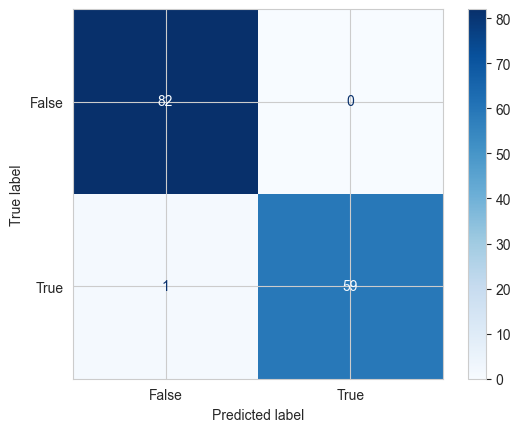

In [47]:
dsp = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=tree.classes_
)
dsp.plot(cmap="Blues")

If, instead of the labels, we take the probabilities, we can calculate the ROC curve. ROC (Receiver Operating Characteristic) curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) for the different possible cutpoints of a diagnostic test. It is a standard way to visualize the performance of a binary classifier.

Text(0, 0.5, 'Number of nodes')

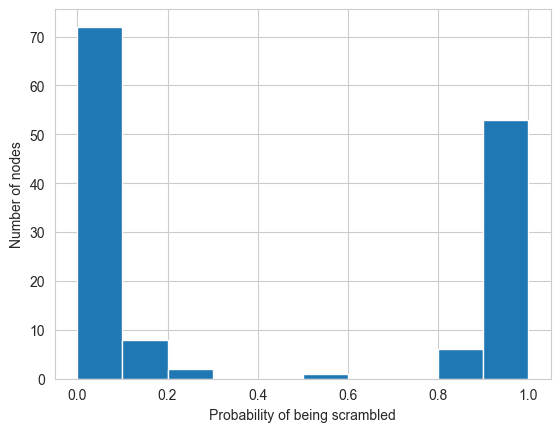

In [48]:
predicted_proba = forest.predict_proba(df_classification)
plt.hist(predicted_proba[:, 1], bins=10)
plt.xlabel("Probability of being scrambled")
plt.ylabel("Number of nodes")

Text(0.5, 1.0, 'ROC curve, AUC=0.9999999999999999')

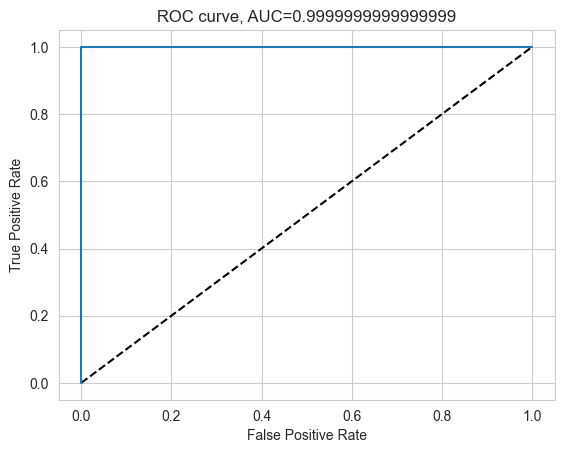

In [49]:
predicted_proba = forest.predict_proba(df_classification)
fpr, tpr, _ = sklearn.metrics.roc_curve(observed, predicted_proba[:, 1])
auc = sklearn.metrics.roc_auc_score(observed, predicted_proba[:, 1])
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], "--k")
ax.plot(fpr, tpr)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"ROC curve, AUC={auc}")

Both the ROC curve and the classification report are unrealistically good. This is because we are evaluating the model on the training set. In practice, we would split the data into training and testing sets, and we would evaluate the model on the testing set.